In [62]:
import sys
import os
import datasets
from dotenv import dotenv_values
from pathlib import Path
from scipy.special import softmax
import pandas as pd
import numpy as np
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
np.random.seed(19950808)

# take environment variables from .env.
config = dotenv_values("./../../config/.env")
base_path = Path(config["BASE_PATH"])
sys.path.append(str(base_path/"code"))

In [63]:
gt = pd.read_pickle(base_path/"data/labeling/GT.pkl")
gt = gt[(gt.labeled == True) & (gt.strategy == "sequential")]

# Evaluating Different Models

In [27]:
model_pred = {
    "loss": {},
    "unexpected": {}
    }

data_folder_path = base_path/"data/evaluation"
for target in ["loss", "unexpected"]:
    dataset_path = data_folder_path/target
    for dataset in os.listdir(dataset_path):
        if dataset == "eval":
            data = datasets.load_from_disk(dataset_path/dataset)
            df = data.to_pandas()
            df["p_ensemble"] = df[[col for col in df.columns if col[:2] == "p_"]].mean(axis=1)
            df = df[["report_id", "paragraph_nr", "p_ensemble"]]
            dataset = "Ze"
        elif dataset in ["eval-iteration-3", "eval-ft-base", "eval-ft-large", "eval-distill-base"]:
            data = datasets.load_from_disk(dataset_path/dataset)
            df = data.to_pandas()
            for col in df.columns:
                if col[:6] == "logits":
                    new_col = "_".join(["p"] + col.split("_")[1:])
                    df[new_col]= softmax(df[col].tolist(), axis=1)[:,0]
                    df = df[["report_id", "paragraph_nr"] + [new_col]]
            if dataset == "eval-iteration-3":
                dataset = "ZeDiAc-large"
            elif dataset == "eval-ft-base":
                dataset = "Ac-base"
            elif dataset == "eval-ft-large":
                dataset = "Ac-large"
            elif dataset == "eval-distill-base":
                dataset = "ZeDi-base"
        for col in df.columns:
            if col[:2] == "p_":
                y_pred = (gt.merge(df, on=["report_id", "paragraph_nr"], how='left')[col]>0.5).tolist()
                model_pred[target][f"{dataset}"] =  y_pred

In [60]:
scores = {
    "loss": {},
    "unexpected": {},
    }

for target in ["loss", "unexpected"]:
    y_gt = gt[target].tolist()
    for key in model_pred[target]:
        y_pred = model_pred[target][key]
        conf_mat = confusion_matrix(y_gt, y_pred)
        scores[target][key] = {
            "F1": f1_score(y_gt, y_pred, average="binary"),
            "Precision": precision_score(y_gt, y_pred, average="binary", zero_division=0),
            "Recall": recall_score(y_gt, y_pred, average="binary"),
            "F2": fbeta_score(y_gt, y_pred, beta=2, average="binary"),
            "AUC-ROC": roc_auc_score(y_gt, y_pred),
            "TP": conf_mat[1,1],
            "FP": conf_mat[0,1],
            "FN": conf_mat[1,0],
            "TN": conf_mat[0,0]
        }

### Loss

In [61]:
pd.DataFrame(scores["unexpected"])[["Ze", "ZeDi-base", "ZeDiAc-large", "Ac-large", "Ac-base"]].T.round(3)

,F1,Precision,Recall,F2,AUC-ROC,TP,FP,FN,TN
Ze,0.353,0.462,0.286,0.309,0.642,6.0,7.0,15.0,2738.0
ZeDi-base,0.000,0.000,0.000,0.000,0.500,0.0,0.0,21.0,2745.0
ZeDiAc-large,0.760,0.655,0.905,0.841,0.951,19.0,10.0,2.0,2735.0
Ac-large,0.000,0.000,0.000,0.000,0.500,0.0,0.0,21.0,2745.0
Ac-base,0.000,0.000,0.000,0.000,0.500,0.0,0.0,21.0,2745.0


### Unexpected

In [55]:
pd.DataFrame(scores["loss"])[["Ze", "ZeDi-base", "ZeDiAc-large", "Ac-large", "Ac-base"]].T.round(3)

,F1,Precision,Recall,F2,AUC-ROC,TP,FP,FN,TN
Ze,0.468,0.612,0.380,0.411,0.684,52.0,33.0,85.0,2596.0
ZeDi-base,0.524,0.471,0.591,0.562,0.778,81.0,91.0,56.0,2538.0
ZeDiAc-large,0.636,0.733,0.562,0.590,0.776,77.0,28.0,60.0,2601.0
Ac-large,0.649,0.830,0.533,0.574,0.764,73.0,15.0,64.0,2614.0
Ac-base,0.000,0.000,0.000,0.000,0.500,0.0,0.0,137.0,2629.0


# Evaluating Zero-Shot performance of different Models, Targets, and Labels

In [64]:
print("F1 Scores: ")
for target in ["loss", "unexpected"]:
    print("")
    print("#" *30)
    print("")
    print("Target: ", target)
    print("")
    data = datasets.load_from_disk(data_folder_path/target/"eval")
    df = data.to_pandas()
    df = gt.merge(df[[col for col in df.columns if col[:2] == "p_"]+["report_id", "paragraph_nr"]], on =["report_id", "paragraph_nr"], how="left")

    y_pred = {}
    for col in [col for col in df.columns if col[:2] == "p_"]:
        y_pred[col] = (df[col]>0.5).to_list()

    
    for col in y_pred:
        y = y_pred[col]
        model = "RoBERTa" if col.split("_")[2] == "D" else "DeBERTa"
        print(model, col.split("_")[3], col.split("_")[4], ":", round(classification_report(df.loss.tolist(), y, output_dict=True)['1']["f1-score"], 3))

F1 Scores: 

##############################

Target:  loss

RoBERTa T1 L1 : 0.254
RoBERTa T1 L2 : 0.434
RoBERTa T1 L3 : 0.25
RoBERTa T1 L4 : 0.426
RoBERTa T2 L1 : 0.283
RoBERTa T2 L2 : 0.348
RoBERTa T2 L3 : 0.35
RoBERTa T2 L4 : 0.343
DeBERTa T1 L1 : 0.172
DeBERTa T1 L2 : 0.426
DeBERTa T1 L3 : 0.319
DeBERTa T1 L4 : 0.439
DeBERTa T2 L1 : 0.147
DeBERTa T2 L2 : 0.317
DeBERTa T2 L3 : 0.274

##############################

Target:  unexpected

RoBERTa T1 U1 : 0.0
RoBERTa T1 U2 : 0.0
RoBERTa T1 U3 : 0.272
RoBERTa T1 U4 : 0.038
RoBERTa T1 U5 : 0.0
RoBERTa T2 U1 : 0.117
RoBERTa T2 U2 : 0.0
RoBERTa T2 U3 : 0.185
RoBERTa T2 U4 : 0.248
RoBERTa T2 U5 : 0.013
DeBERTa T1 U1 : 0.041
DeBERTa T1 U2 : 0.014
DeBERTa T1 U3 : 0.067
DeBERTa T1 U4 : 0.1
DeBERTa T1 U5 : 0.0
DeBERTa T2 U1 : 0.251
DeBERTa T2 U2 : 0.227
DeBERTa T2 U3 : 0.233
DeBERTa T2 U4 : 0.328


# Evaluating LLMs

In [58]:
llm = pd.read_pickle(base_path/"data/evaluation/Eval-LLMs.pkl")
llm = llm[llm.labeled]

llm_pred_and_gt = {
    "loss": {},
    "unexpected": {}
}
for target in ["loss", "unexpected"]:
    for provider in ["cohere", "openai"]:
        dff = gt.merge(llm, on=["report_id", "paragraph_nr"], how='right')
        y_pred = dff[f"{provider}_{target}"].tolist()
        y_true = dff[target].tolist()
        llm_pred_and_gt[target][f"{provider}"] =  y_pred
        llm_pred_and_gt[target]["gt"] = y_true

scores = {
    "loss": {},
    "unexpected": {},
    }

for target in ["loss", "unexpected"]:
    y_gt = llm_pred_and_gt[target]["gt"]
    for key in llm_pred_and_gt[target]:
        y_pred = llm_pred_and_gt[target][key]
        conf_mat = confusion_matrix(y_gt, y_pred)
        scores[target][key] = {
            "F1": f1_score(y_gt, y_pred, average="binary"),
            "Precision": precision_score(y_gt, y_pred, average="binary", zero_division=0),
            "Recall": recall_score(y_gt, y_pred, average="binary"),
            "F2": fbeta_score(y_gt, y_pred, beta=2, average="binary"),
            "AUC-ROC": roc_auc_score(y_gt, y_pred),
            "TP": conf_mat[1,1],
            "FP": conf_mat[0,1],
            "FN": conf_mat[1,0],
            "TN": conf_mat[0,0]
        }

/home/andreas/Polybox/Project-Support-Material/Thesis/.venv/lib/python3.10/site-packages/sklearn/utils/multiclass.py:380: RuntimeWarning: invalid value encountered in cast
  if xp.any(data != data.astype(int)):


ValueError: Input y_true contains NaN.

# Some Backup Visualizations

Model: ZeDi-base
Binary F1: 0.5242718446601943
Binary F2: 0.5625
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2629
           1       0.47      0.59      0.52       137

    accuracy                           0.95      2766
   macro avg       0.72      0.78      0.75      2766
weighted avg       0.95      0.95      0.95      2766

ROC: 0.7783134771345993
Confusion Matrix:
[[2538   91]
 [  56   81]]
 
Model: Ze
Binary F1: 0.46846846846846846
Binary F2: 0.41074249605055296
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2629
           1       0.61      0.38      0.47       137

    accuracy                           0.96      2766
   macro avg       0.79      0.68      0.72      2766
weighted avg       0.95      0.96      0.95      2766

ROC: 0.6835048712701952
Confusion Matrix:
[[2596   33]
 [  85   52]]
 
Model: Ac-large
Binary F1: 0.6488888888888888
Binary F2: 0.57389937

/home/andreas/Polybox/Project-Support-Material/Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andreas/Polybox/Project-Support-Material/Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/andreas/Polybox/Project-Support-Material/Thesis/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete

Confusion Matrix:
[[2601   28]
 [  60   77]]
 


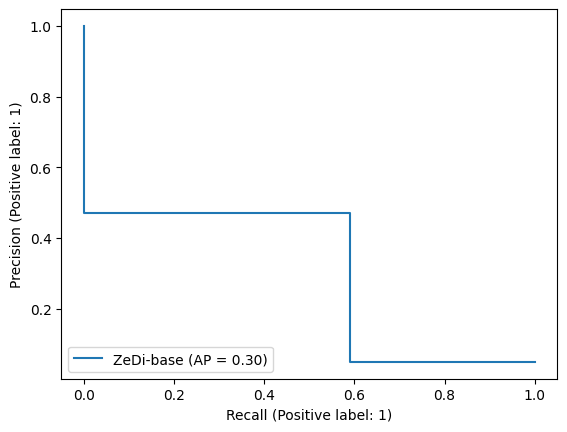

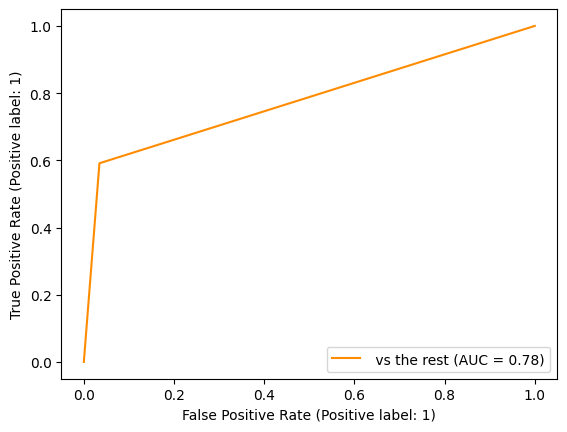

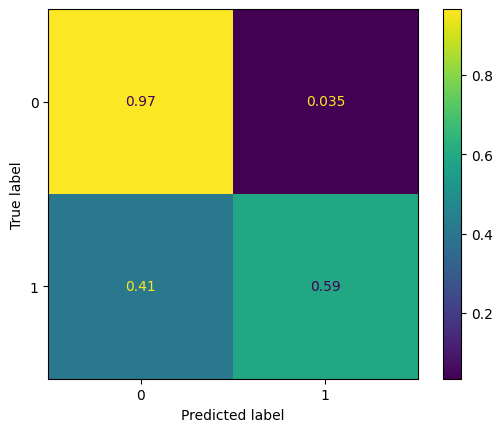

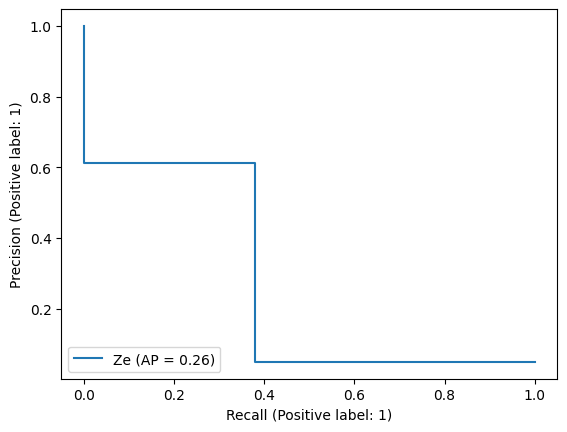

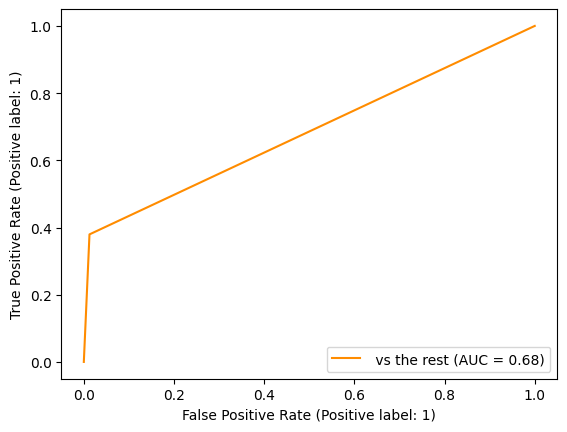

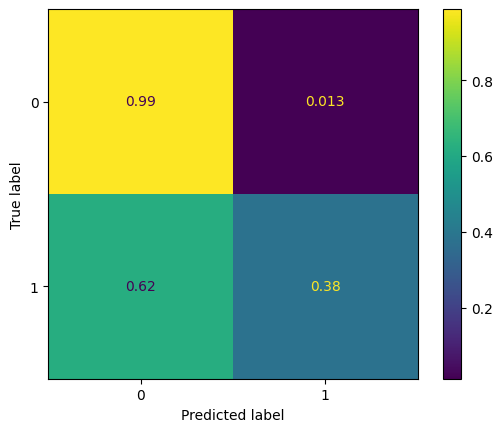

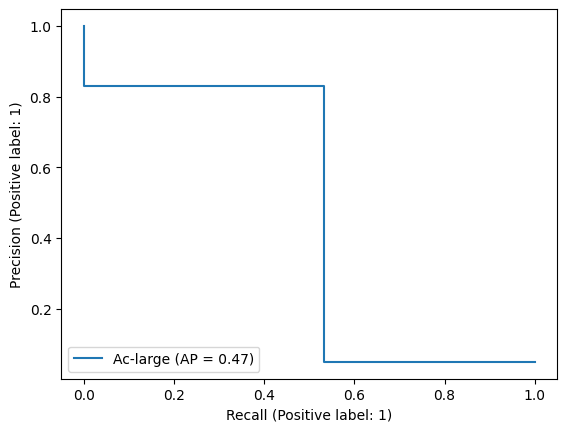

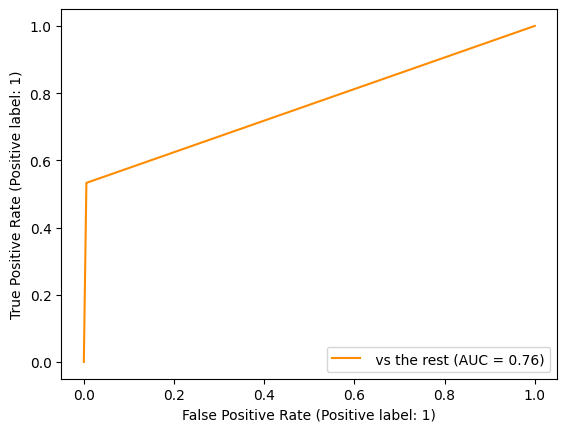

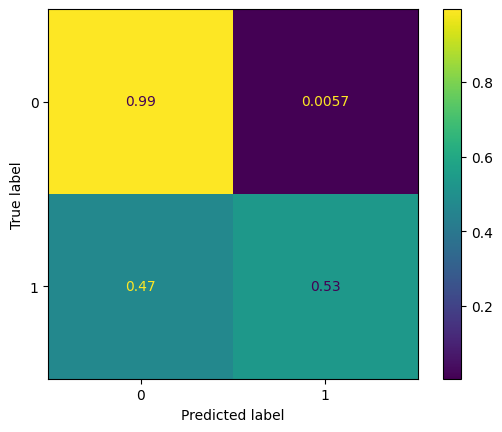

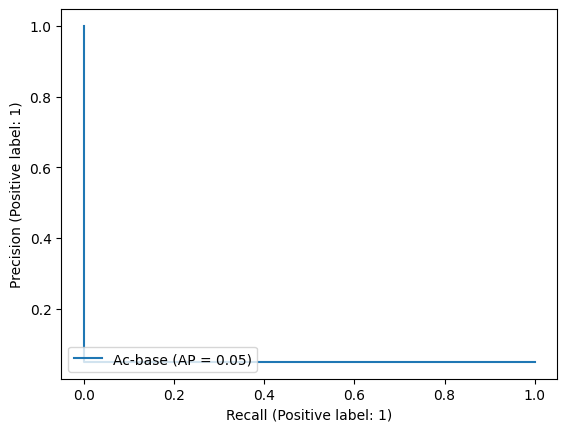

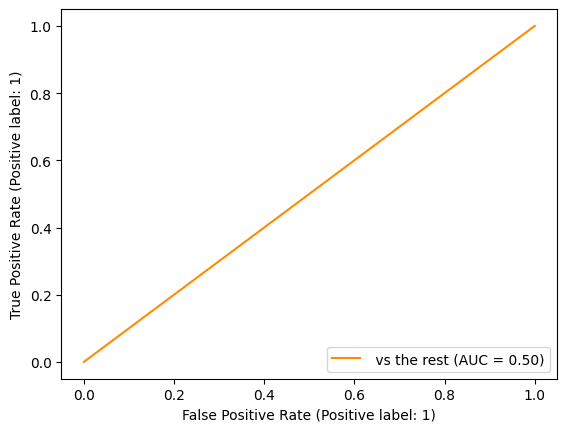

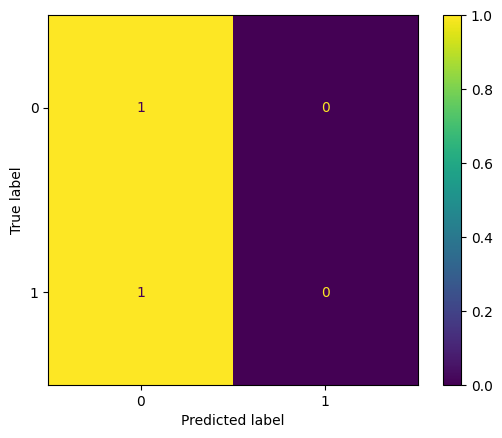

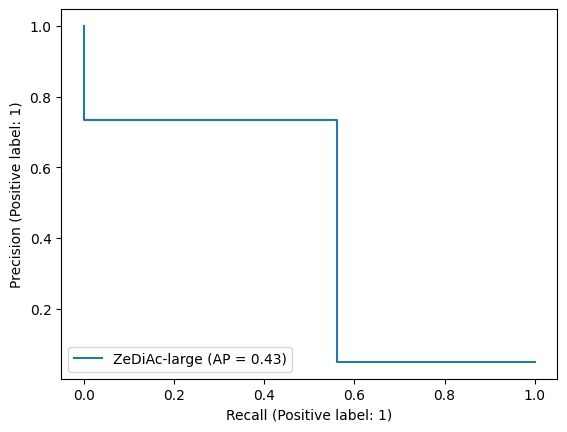

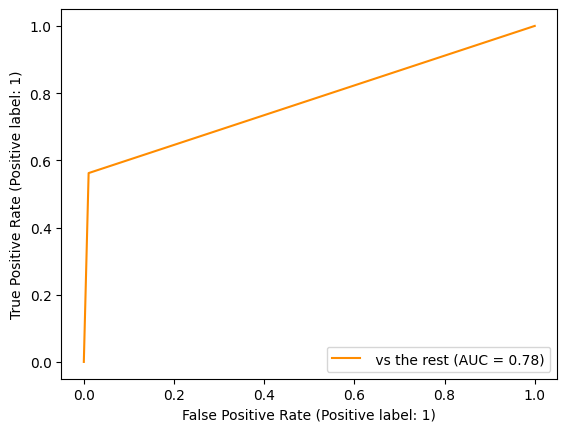

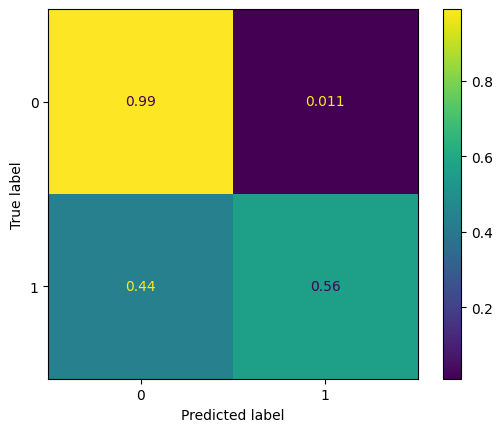

In [57]:
target = "loss"
y_gt = gt[target].tolist()
for key in model_pred[target]:
    print("Model:", key)
    y_pred = model_pred[target][key]
    print("Binary F1:", f1_score(y_gt, y_pred, average="binary"))
    print("Binary F2:", fbeta_score(y_gt, y_pred, beta=2, average="binary"))
    print(classification_report(y_gt, y_pred ))
    display = PrecisionRecallDisplay.from_predictions(y_gt, y_pred, name=key)
    print("ROC:", roc_auc_score(y_gt, y_pred))
    RocCurveDisplay.from_predictions(
        y_gt,
        y_pred,
        name=f" vs the rest",
        color="darkorange",
    )
    print("Confusion Matrix:")
    print(confusion_matrix(y_gt, y_pred))
    print(" ")
    ConfusionMatrixDisplay.from_predictions(
        y_gt,
        y_pred,
        normalize="true")